In [1]:
import json
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.models.word2vec import Word2Vec
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import numpy as np
from matplotlib import pyplot as plt

In [2]:
with open("stored_variables/politics_author_history.json", "r") as f:
    politics_author_history = json.load(f)

In [3]:
print(len(list(politics_author_history.values())[0]))

15149


In [4]:
sorted(list(politics_author_history.values())[0], key = lambda x : x[1])

[['reddit.com', 1135471163],
 ['reddit.com', 1136262610],
 ['reddit.com', 1136992548],
 ['reddit.com', 1139503715],
 ['reddit.com', 1139547140],
 ['reddit.com', 1142234596],
 ['reddit.com', 1142276688],
 ['reddit.com', 1142369982],
 ['reddit.com', 1142587416],
 ['reddit.com', 1142587685],
 ['reddit.com', 1142736120],
 ['reddit.com', 1142747591],
 ['reddit.com', 1143159452],
 ['reddit.com', 1143160487],
 ['reddit.com', 1143179440],
 ['reddit.com', 1143663272],
 ['reddit.com', 1143663404],
 ['reddit.com', 1143832504],
 ['reddit.com', 1143833556],
 ['reddit.com', 1143942942],
 ['reddit.com', 1143943213],
 ['reddit.com', 1143998717],
 ['reddit.com', 1144213581],
 ['reddit.com', 1144266218],
 ['reddit.com', 1144606226],
 ['reddit.com', 1144606450],
 ['reddit.com', 1144695028],
 ['reddit.com', 1144695104],
 ['reddit.com', 1144714992],
 ['reddit.com', 1144737824],
 ['reddit.com', 1144783524],
 ['reddit.com', 1144884930],
 ['reddit.com', 1145152082],
 ['reddit.com', 1145239465],
 ['reddit.com'

In [5]:
list(politics_author_history.keys())[:5]

['Psy-Kosh', 'Qwirk', 'Archer007', 'trivial', 'apodo']

In [6]:
input_subreddit_list = []
author_names = []

for k in politics_author_history.keys():
    input_subreddit_list.append(sorted(politics_author_history[k], key = lambda x : x[1]))
    author_names.append(k)

In [7]:
input_subreddit_list = [[x[0] for x in l] for l in input_subreddit_list]

(array([1.798e+03, 1.300e+02, 3.500e+01, 2.000e+01, 5.000e+00, 4.000e+00,
        4.000e+00, 2.000e+00, 1.000e+00, 1.000e+00]),
 array([1.00000e+00, 3.94510e+03, 7.88920e+03, 1.18333e+04, 1.57774e+04,
        1.97215e+04, 2.36656e+04, 2.76097e+04, 3.15538e+04, 3.54979e+04,
        3.94420e+04]),
 <a list of 10 Patch objects>)

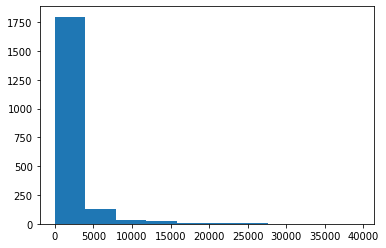

In [8]:
history_lengths = [len(l) for l in input_subreddit_list]

plt.hist(history_lengths)

(array([995., 325., 155., 118.,  67.,  53.,  50.,  37.,  27.,  17.]),
 array([1.0000e+00, 5.0020e+02, 9.9940e+02, 1.4986e+03, 1.9978e+03,
        2.4970e+03, 2.9962e+03, 3.4954e+03, 3.9946e+03, 4.4938e+03,
        4.9930e+03]),
 <a list of 10 Patch objects>)

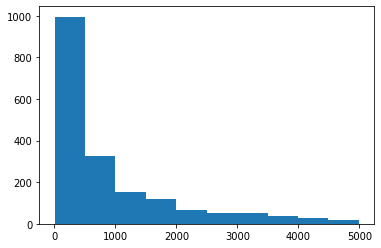

In [9]:
plt.hist([i for i in history_lengths if i < 5000])

(array([417., 230., 141., 111.,  96.,  91.,  79.,  64.,  49.,  42.]),
 array([  1. , 100.8, 200.6, 300.4, 400.2, 500. , 599.8, 699.6, 799.4,
        899.2, 999. ]),
 <a list of 10 Patch objects>)

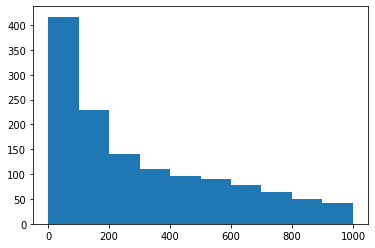

In [10]:
plt.hist([i for i in history_lengths if i < 1000])

In [11]:
print("Mean history length:", np.mean(history_lengths))
print("Standard deviation of history lengths:", np.std(history_lengths))

Mean history length: 1569.1905
Standard deviation of history lengths: 3137.4876406465332


## Create Doc2Vec embeddings of the subreddits

In [12]:
user_docs = [TaggedDocument(input_subreddit_list[i], [author_names[i]]) for i in range(len(input_subreddit_list))]
subreddit_hist_model = Doc2Vec(user_docs, vector_size=50, window=10, min_count=5)

In [13]:
user_docs[0]

TaggedDocument(words=['reddit.com', 'reddit.com', 'reddit.com', 'reddit.com', 'reddit.com', 'reddit.com', 'reddit.com', 'reddit.com', 'reddit.com', 'reddit.com', 'reddit.com', 'reddit.com', 'reddit.com', 'reddit.com', 'reddit.com', 'reddit.com', 'reddit.com', 'reddit.com', 'reddit.com', 'reddit.com', 'reddit.com', 'reddit.com', 'reddit.com', 'reddit.com', 'reddit.com', 'reddit.com', 'reddit.com', 'reddit.com', 'reddit.com', 'reddit.com', 'reddit.com', 'reddit.com', 'reddit.com', 'reddit.com', 'reddit.com', 'reddit.com', 'reddit.com', 'reddit.com', 'reddit.com', 'reddit.com', 'reddit.com', 'reddit.com', 'reddit.com', 'reddit.com', 'reddit.com', 'reddit.com', 'reddit.com', 'reddit.com', 'reddit.com', 'reddit.com', 'reddit.com', 'reddit.com', 'reddit.com', 'reddit.com', 'reddit.com', 'reddit.com', 'reddit.com', 'reddit.com', 'reddit.com', 'reddit.com', 'reddit.com', 'reddit.com', 'programming', 'reddit.com', 'reddit.com', 'reddit.com', 'reddit.com', 'reddit.com', 'reddit.com', 'reddit.com

In [14]:
subreddit_hist_model.docvecs['Psy-Kosh']

array([-2.4683278 , -3.0050259 , -2.7404635 , -0.96124166,  1.9458584 ,
        4.458974  , -1.2062814 ,  0.86026084, -4.044754  , -0.31109667,
       -1.1105186 ,  3.0088234 , -0.9160648 ,  0.43204188, -1.9426972 ,
        2.542826  ,  1.6801233 ,  2.727232  ,  2.9659379 , -1.7918266 ,
       -1.8140987 ,  0.99085355, -4.930917  ,  0.38337985, -1.7399812 ,
       -0.9411905 , -2.9412885 , -2.0980217 ,  2.2342324 , -1.5712514 ,
        1.0581442 , -1.872529  , -2.0433154 ,  0.49331224, -1.3576088 ,
        0.76100504,  4.49972   , -1.2938184 , -0.15350167, -2.224298  ,
       -2.8292625 ,  3.9528422 , -2.3279097 , -0.29306108, -2.5100589 ,
       -1.3215646 ,  1.960824  , -2.7541199 ,  3.4298828 ,  1.807897  ],
      dtype=float32)

In [15]:
subreddit_hist_vecs = np.array([subreddit_hist_model.docvecs[i] for i in author_names])

## Visualize document vectors with PCA and T-SNE

In [16]:
subreddit_pca = PCA(n_components=2)
subreddit_pca_points = subreddit_pca.fit_transform(subreddit_hist_vecs)
subreddit_pca.explained_variance_ratio_

array([0.12898816, 0.06158366], dtype=float32)

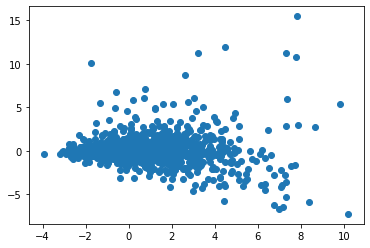

In [17]:
plt.scatter(subreddit_pca_points[:,0], subreddit_pca_points[:,1])
plt.show()

In [18]:
subreddit_tsne = TSNE(n_components=2)
subreddit_tsne_points = subreddit_tsne.fit_transform(subreddit_hist_vecs)

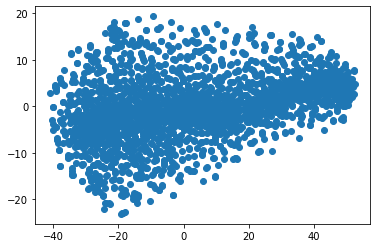

In [19]:
plt.scatter(subreddit_tsne_points[:,0], subreddit_tsne_points[:,1])
plt.show()

## What are the axes?

In [20]:
# first axis
subreddit_pca.components_[0]



array([-0.10224006, -0.01873132, -0.1813945 ,  0.09093302,  0.1288852 ,
        0.1714462 , -0.13712184, -0.0030344 , -0.18620346, -0.0969152 ,
       -0.20321532,  0.17928721, -0.1748412 , -0.14070818,  0.1186432 ,
       -0.09554113, -0.04006919,  0.09629913,  0.12140092, -0.24743433,
       -0.2618661 , -0.07810742, -0.03432538,  0.03211484, -0.03001996,
        0.15405394, -0.15765207, -0.17722921, -0.14361373, -0.00385214,
       -0.00600858,  0.02934982, -0.12749135,  0.1479842 , -0.27461854,
       -0.20494871,  0.15239915, -0.16090164, -0.10768016, -0.04546446,
       -0.05243444,  0.22629255,  0.08801697, -0.11601042, -0.10466512,
       -0.18045433, -0.05038809, -0.10938692,  0.05468691,  0.26728797],
      dtype=float32)

## K-means clustering

In [79]:
km2 = KMeans(n_clusters=2)
km2.fit(subreddit_hist_vecs)
km2_labels = km2.labels_
color_vals = ['red', 'blue', 'green', 'orange', 'purple', 'black', 'cyan', 'magenta', 'yellow', 'brown']
km2_label_colors = [color_vals[i] for i in km2_labels]

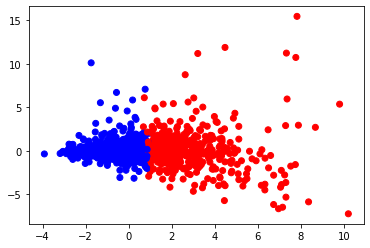

In [22]:
plt.scatter(subreddit_pca_points[:,0], subreddit_pca_points[:,1], c=km2_label_colors)
plt.show()

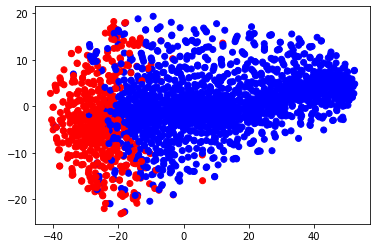

In [23]:
plt.scatter(subreddit_tsne_points[:,0], subreddit_tsne_points[:,1], c=km2_label_colors)
plt.show()

In [24]:
km3 = KMeans(n_clusters=3)
km3.fit(subreddit_hist_vecs)
km3_label_colors = [color_vals[i] for i in km3.labels_]

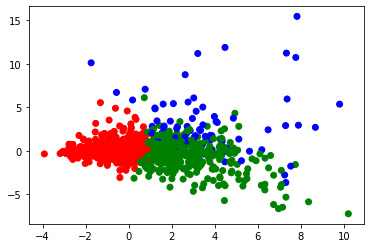

In [25]:
plt.scatter(subreddit_pca_points[:,0], subreddit_pca_points[:,1], c=km3_label_colors)
plt.show()

In [26]:
km4 = KMeans(n_clusters=4)
km4.fit(subreddit_hist_vecs)
km4_label_colors = [color_vals[i] for i in km4.labels_]

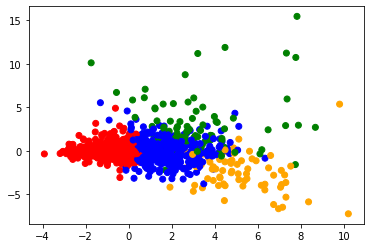

In [27]:
plt.scatter(subreddit_pca_points[:,0], subreddit_pca_points[:,1], c=km4_label_colors)
plt.show()

## PCA and clustering on original subreddit vectors

In [28]:
all_subreddits = sorted(list(set([i for l in input_subreddit_list for i in l])))
subreddit_reverse_dict = {all_subreddits[i] : i for i in range(len(all_subreddits))}
subreddit_tf = np.zeros((len(input_subreddit_list), len(all_subreddits)))

for i in range(len(input_subreddit_list)):
    for s in input_subreddit_list[i]:
        subreddit_tf[i, subreddit_reverse_dict[s]] += 1


In [29]:
print(len(np.sum(subreddit_tf, axis=0)))
print(len(all_subreddits))

14606
14606


In [30]:
subreddit_df = np.sum(np.where(subreddit_tf > 0, 1, 0), axis=0)
subreddit_idf = len(input_subreddit_list) / subreddit_df

subreddit_tfidf = subreddit_tf * subreddit_idf
subreddit_tfidf = subreddit_tfidf / np.sum(subreddit_tfidf, axis=1)[:, np.newaxis]

In [31]:
print(subreddit_tfidf.shape)
print(subreddit_idf.shape)
print(np.sum(subreddit_tfidf, axis=1).shape)

(2000, 14606)
(14606,)
(2000,)


In [37]:
raw_pca = PCA(n_components=50)
raw_pca_points = raw_pca.fit_transform(subreddit_tfidf)
raw_pca.explained_variance_ratio_

array([0.1014779 , 0.00614029, 0.00591811, 0.00550361, 0.00454076,
       0.00443875, 0.00426256, 0.00368262, 0.0034857 , 0.00324452,
       0.00320738, 0.00300508, 0.00298905, 0.00258112, 0.00254257,
       0.00243451, 0.00227498, 0.00226499, 0.00224593, 0.00220792,
       0.00218122, 0.00215128, 0.00215083, 0.00210917, 0.00206028,
       0.00203778, 0.0020228 , 0.00199712, 0.00198148, 0.00195925,
       0.00194233, 0.00192331, 0.00186806, 0.00184609, 0.00182595,
       0.00182265, 0.00180495, 0.00175636, 0.00174695, 0.00174342,
       0.00173172, 0.00171631, 0.00170876, 0.00170268, 0.00169886,
       0.0016913 , 0.00168549, 0.00167044, 0.00165093, 0.00164808])

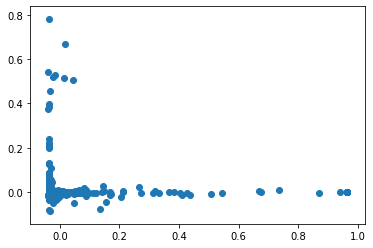

In [38]:
plt.scatter(raw_pca_points[:,0], raw_pca_points[:,1])
plt.show()

In [39]:
# importance order might be misleading: largest coefficients
subreddit_importance_order1 = list(np.argsort(np.abs(raw_pca.components_[0])))
subreddit_importance_order1.reverse()

for i in range(20):
    print(all_subreddits[subreddit_importance_order1[i]])
    
print()

subreddit_importance_order2 = list(np.argsort(np.abs(raw_pca.components_[1])))
subreddit_importance_order2.reverse()

for i in range(20):
    print(all_subreddits[subreddit_importance_order2[i]])

politics
SandersForPresident
AskReddit
news
todayilearned
hillaryclinton
russia
videos
PoliticalDiscussion
leagueoflegends
DotA2
OutOfTheLoop
worldnews
movies
nba
dataisbeautiful
nfl
SquaredCircle
reddevils
CFB

nba
leagueoflegends
The_Donald
nfl
AskReddit
Music
guysgonewild
LoLeventVoDs
SLRep
SandersForPresident
DotA2
news
ggRO
NYKnicks
CFB
triangle
BestThings
Mr_Trump
nsfw_gifs
hillaryclinton


In [41]:
km2_pca = KMeans(n_clusters=2)
km2_pca.fit(raw_pca_points)
km2_pca_label_colors = [color_vals[i] for i in km2_pca.labels_]

In [80]:
km10_pca = KMeans(n_clusters=10)
km10_pca.fit(raw_pca_points)
km10_pca_label_colors = [color_vals[i] for i in km10_pca.labels_]

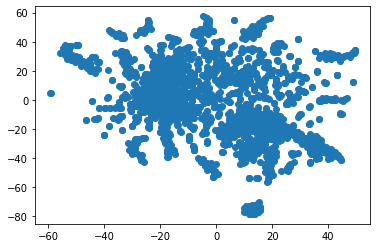

In [73]:
raw_tsne = TSNE(n_components=2)
raw_tsne_points = raw_tsne.fit_transform(raw_pca_points)
plt.scatter(raw_tsne_points[:,0], raw_tsne_points[:,1])
plt.show()

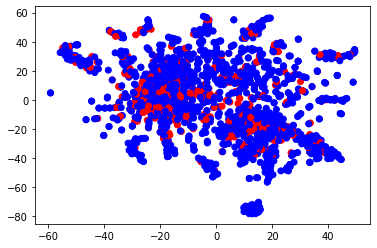

In [74]:
plt.scatter(raw_tsne_points[:,0], raw_tsne_points[:,1], c = km2_label_colors)
plt.show()

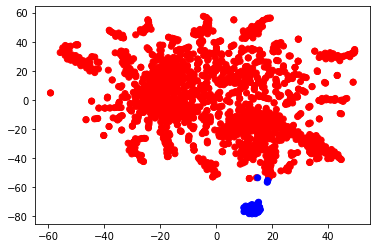

In [81]:
plt.scatter(raw_tsne_points[:,0], raw_tsne_points[:,1], c = km2_pca_label_colors)
plt.show()

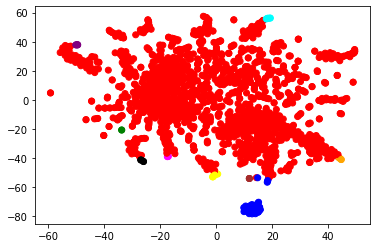

In [83]:
plt.scatter(raw_tsne_points[:,0], raw_tsne_points[:,1], c = km10_pca_label_colors)
plt.show()

## Top subreddits

In [55]:
subreddit_freqs = np.sum(subreddit_tf, axis=0)
top_subreddits = [(all_subreddits[i], int(subreddit_freqs[i])) for i in np.argsort(subreddit_freqs)]
top_subreddits.reverse()

for i in top_subreddits[:50]:
    print(i[0] + ": " + str(i[1]))

AskReddit: 278749
politics: 125588
funny: 98759
pics: 89709
gaming: 61388
worldnews: 61130
WTF: 53774
AdviceAnimals: 50934
todayilearned: 49555
videos: 48963
news: 48711
atheism: 48668
nfl: 48187
leagueoflegends: 35713
nba: 32024
IAmA: 31211
technology: 28570
movies: 27335
CFB: 24567
Games: 23418
hockey: 22564
trees: 19967
reddit.com: 16788
pcmasterrace: 15778
DotA2: 15167
Christianity: 15059
gifs: 14679
explainlikeimfive: 13804
SandersForPresident: 13572
SquaredCircle: 13015
TumblrInAction: 12614
xboxone: 12479
science: 11320
KotakuInAction: 11256
aww: 10970
Economics: 10695
DestinyTheGame: 10164
PoliticalDiscussion: 9976
The_Donald: 9976
asoiaf: 9902
soccer: 9876
Music: 9876
wow: 9565
fantasyfootball: 9261
gonewild: 9222
Fitness: 9115
programming: 9041
starcraft: 8967
hearthstone: 8710
europe: 8656


In [57]:
print(subreddit_freqs[subreddit_reverse_dict['The_Donald']])
print(subreddit_freqs[subreddit_reverse_dict['SandersForPresident']])
print(subreddit_freqs[subreddit_reverse_dict['hillaryclinton']])

9976.0
13572.0
695.0


In [59]:
top_subreddits_df = [(all_subreddits[i], int(subreddit_df[i])) for i in np.argsort(subreddit_df)]
top_subreddits_df.reverse()

for i in top_subreddits_df[:50]:
    print(i[0] + ": " + str(i[1]))

politics: 2000
AskReddit: 1686
pics: 1510
funny: 1498
todayilearned: 1427
worldnews: 1355
videos: 1330
WTF: 1217
gaming: 1195
AdviceAnimals: 1189
news: 1175
IAmA: 1174
movies: 1071
technology: 1013
gifs: 971
aww: 943
Music: 914
atheism: 881
science: 816
explainlikeimfive: 741
mildlyinteresting: 668
Showerthoughts: 650
nottheonion: 570
television: 552
LifeProTips: 530
SandersForPresident: 526
trees: 492
bestof: 468
tifu: 459
books: 458
pcmasterrace: 443
woahdude: 432
food: 425
cringepics: 404
Futurology: 402
dataisbeautiful: 401
Fitness: 387
reactiongifs: 381
sports: 374
Jokes: 357
askscience: 353
personalfinance: 353
creepy: 349
OldSchoolCool: 347
interestingasfuck: 346
Games: 342
TwoXChromosomes: 334
BlackPeopleTwitter: 331
JusticePorn: 330
DIY: 328


In [60]:
print(subreddit_df[subreddit_reverse_dict['The_Donald']])
print(subreddit_df[subreddit_reverse_dict['SandersForPresident']])
print(subreddit_df[subreddit_reverse_dict['hillaryclinton']])

295
526
64


In [68]:
print(np.sum(np.where(subreddit_tf > 0, 1, 0)[:,subreddit_reverse_dict['The_Donald']] * 
       np.where(subreddit_tf > 0, 1, 0)[:,subreddit_reverse_dict['SandersForPresident']]))
print(np.sum(np.where(subreddit_tf > 0, 1, 0)[:,subreddit_reverse_dict['The_Donald']] * 
       np.where(subreddit_tf > 0, 1, 0)[:,subreddit_reverse_dict['hillaryclinton']]))
print(np.sum(np.where(subreddit_tf > 0, 1, 0)[:,subreddit_reverse_dict['SandersForPresident']] * 
       np.where(subreddit_tf > 0, 1, 0)[:,subreddit_reverse_dict['hillaryclinton']]))

163
21
41


In [69]:
raw_pca_points.shape

(2000, 50)

In [96]:
subreddit_pca_vecs = raw_pca.transform(np.identity(len(all_subreddits)))

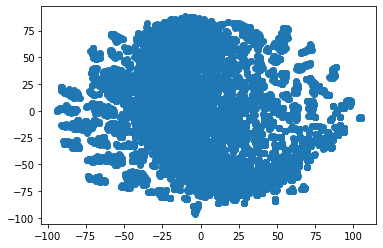

In [97]:
subreddit_pca_tsne = TSNE(n_components=2)
subreddit_pca_tsne_points = subreddit_pca_tsne.fit_transform(subreddit_pca_vecs)
plt.scatter(subreddit_pca_tsne_points[:,0], subreddit_pca_tsne_points[:,1])
plt.show()

In [98]:
km2_sub = KMeans(n_clusters=2)
km2_sub.fit(subreddit_pca_vecs)
km2_sub_label_colors = [color_vals[i] for i in km2_sub.labels_]

In [99]:
km10_sub = KMeans(n_clusters=10)
km10_sub.fit(subreddit_pca_vecs)
km10_sub_label_colors = [color_vals[i] for i in km10_sub.labels_]

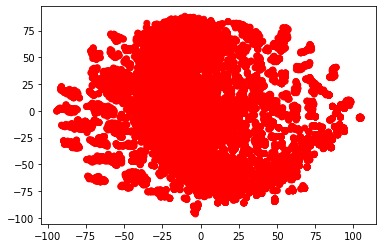

In [100]:
plt.scatter(subreddit_pca_tsne_points[:,0], subreddit_pca_tsne_points[:,1], c=km2_sub_label_colors)
plt.show()

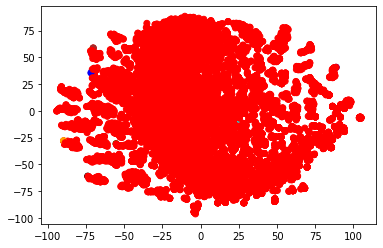

In [101]:
plt.scatter(subreddit_pca_tsne_points[:,0], subreddit_pca_tsne_points[:,1], c=km10_sub_label_colors)
plt.show()

In [117]:
# only use subreddits that at least 10 people have posted in 
good_subreddits = [i for i in range(len(all_subreddits)) if subreddit_df[i] >= 10]
good_subreddit_names = [all_subreddits[i] for i in good_subreddits]
good_subreddit_reverse_dict = {good_subreddit_names[i] : i for i in range(len(good_subreddit_names))}
print(len(good_subreddits))
good_subreddit_raw_vecs = np.zeros((len(good_subreddits), len(all_subreddits)))

for i in range(len(good_subreddits)):
    good_subreddit_raw_vecs[i, good_subreddits[i]] = 1
    
good_subreddit_pca_vecs = raw_pca.transform(good_subreddit_raw_vecs)

1946


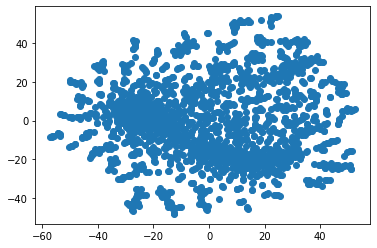

In [107]:
good_subreddit_pca_tsne = TSNE(n_components=2)
good_subreddit_pca_tsne_points = subreddit_pca_tsne.fit_transform(good_subreddit_pca_vecs)
plt.scatter(good_subreddit_pca_tsne_points[:,0], good_subreddit_pca_tsne_points[:,1])
plt.show()

In [108]:
km2_sub_good = KMeans(n_clusters=2)
km2_sub_good.fit(good_subreddit_pca_vecs)
km2_sub_good_label_colors = [color_vals[i] for i in km2_sub_good.labels_]

In [109]:
km10_sub_good = KMeans(n_clusters=10)
km10_sub_good.fit(good_subreddit_pca_vecs)
km10_sub_good_label_colors = [color_vals[i] for i in km10_sub_good.labels_]

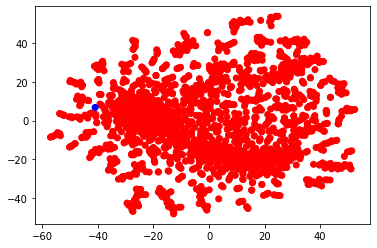

In [110]:
plt.scatter(good_subreddit_pca_tsne_points[:,0], good_subreddit_pca_tsne_points[:,1], c=km2_sub_good_label_colors)
plt.show()

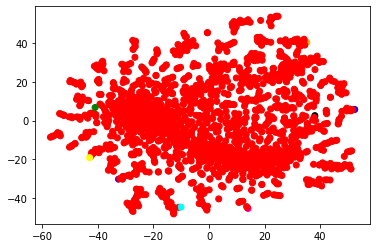

In [111]:
plt.scatter(good_subreddit_pca_tsne_points[:,0], good_subreddit_pca_tsne_points[:,1], c=km10_sub_good_label_colors)
plt.show()

In [119]:
subreddit_sims = np.matmul(good_subreddit_pca_vecs, good_subreddit_pca_vecs.transpose())

top_subreddits_sim = []

for i in range(len(good_subreddits)):
    sim_vals = subreddit_sims[i]
    sub_names = [good_subreddit_names[i] for i in np.argsort(sim_vals)]
    sub_names.reverse()
    top_subreddits_sim.append(sub_names)

In [128]:
print(top_subreddits_sim[good_subreddit_reverse_dict['The_Donald']][:20])
print(top_subreddits_sim[good_subreddit_reverse_dict['SandersForPresident']][:20])
print(top_subreddits_sim[good_subreddit_reverse_dict['hillaryclinton']][:20])
print(top_subreddits_sim[good_subreddit_reverse_dict['politics']][:20])
print(top_subreddits_sim[good_subreddit_reverse_dict['AskReddit']][:20])
print(top_subreddits_sim[good_subreddit_reverse_dict['nba']][:20])

['The_Donald', 'Mr_Trump', 'usanews', 'KotakuInAction', 'NFL_Draft', 'Atlanta', 'GlobalOffensive', 'fo4', 'circlejerk', 'subredditcancer', 'canada', 'gamegrumps', 'UFOs', 'reactiongifs', 'asktransgender', 'european', 'Gunners', 'FreeKarma', 'Roadcam', 'anal']
['SandersForPresident', 'analog', 'harrypotter', 'lost', 'robotics', 'AmericanHorrorStory', 'FreeKarma', 'Jokes', 'WorldofTanks', 'DebateReligion', 'Showerthoughts', 'news', 'Libertarian', 'darksouls3', 'CrusaderKings', 'Conservative', 'Fitness', 'dataisbeautiful', 'HillaryForPrison', 'thesims']
['hillaryclinton', 'enoughsandersspam', 'personalfinance', 'AZCardinals', 'books', 'FIFA', 'magicTCG', 'india', 'analog', 'xboxone', 'clevelandcavs', 'DebateReligion', 'Guildwars2', 'ems', 'Boxing', 'subredditcancer', 'RocketLeague', 'Patriots', 'PS4', 'SRSDiscussion']
['politics', 'russia', 'OutOfTheLoop', 'todayilearned', 'movies', 'videos', 'AskDocs', 'dataisbeautiful', 'LifeProTips', 'CompetitiveHS', 'Military', 'food', 'democrats', 'c

## Word2Vec

In [138]:
subreddit_w2v_model = Word2Vec(input_subreddit_list, size=50, window=100, min_count=10)

In [139]:
print(subreddit_w2v_model.wv.most_similar(positive=['The_Donald']))
print(subreddit_w2v_model.wv.most_similar(positive=['SandersForPresident']))
print(subreddit_w2v_model.wv.most_similar(positive=['hillaryclinton']))
print(subreddit_w2v_model.wv.most_similar(positive=['nba']))
print(subreddit_w2v_model.wv.most_similar(positive=['Frugal']))
print(subreddit_w2v_model.wv.most_similar(positive=['sanfrancisco']))
print(subreddit_w2v_model.wv.most_similar(positive=['Mr_Trump']))

[('NorthAmerican', 0.5889589786529541), ('TheGuessingGame', 0.5607506036758423), ('randpaul', 0.5313757061958313), ('israelexposed', 0.5176153182983398), ('ausstocks', 0.5156495571136475), ('9M9H9E9', 0.5122926235198975), ('internetparents', 0.4981147050857544), ('Denton', 0.47760388255119324), ('Bookkeeping', 0.465756893157959), ('GirlsDancingAwkwardly', 0.4646450877189636)]
[('breastcancer', 0.5838133096694946), ('entp', 0.5475894808769226), ('comicswap', 0.5376862287521362), ('Illinois4Sanders', 0.5354118347167969), ('HillaryForPrison', 0.5288380980491638), ('nyu', 0.5186001062393188), ('CaliforniaForSanders', 0.5067803859710693), ('factorio', 0.4992716312408447), ('BernTheConvention', 0.49836212396621704), ('Mcat', 0.4981282949447632)]
[('ClashRoyale', 0.5219623446464539), ('Doom', 0.5022518634796143), ('gradadmissions', 0.49891942739486694), ('fastfood', 0.49846094846725464), ('PoliticalDiscussion', 0.4855400621891022), ('soma', 0.4848991930484772), ('CountryMusume', 0.47320118546

In [142]:
print(subreddit_df[subreddit_reverse_dict['TheGuessingGame']])
print(subreddit_freqs[subreddit_reverse_dict['TheGuessingGame']])
print(subreddit_df[subreddit_reverse_dict['NorthAmerican']])
print(subreddit_freqs[subreddit_reverse_dict['NorthAmerican']])

1
17.0
3
15.0
